# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow  opencv-python mediapipe scikit-learn matplotlib

In [41]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [42]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [43]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
import mediapipe as mp

# Initialize Mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
mp_face_mesh = mp.solutions.face_mesh  # Import Face Mesh for FACE_CONNECTIONS

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.face_landmarks,
            mp_face_mesh.FACEMESH_TESSELATION,  # Use Face Mesh connections here
            mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1),
        )
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2),
        )
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2),
        )
    # Draw right hand connections  
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
        )


In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
if results.right_hand_landmarks:
    print(len(results.right_hand_landmarks.landmark))
else:
    print("No left hand detected in this frame.")


In [ ]:
results

In [11]:
draw_landmarks(frame, results)

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [ ]:
len(results.left_hand_landmarks.landmark)

In [14]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [15]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [16]:
face = (
    np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
    if results.face_landmarks
    else np.zeros(1404)
)



In [17]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [19]:
result_test = extract_keypoints(results)

In [ ]:
result_test

In [ ]:
468*3+33*4+21*3+21*3

In [22]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Initialize Mediapipe Holistic model
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Path for input videos
VIDEO_PATH = os.path.join('Video_Data')
DATA_PATH = os.path.join('MP_Data')  # Path to save extracted data

# Actions for classification
actions = ['abnormal', 'normal']

# Videos are processed into sequences of 30 frames
sequence_length = 30

# Function to extract keypoints using Mediapipe
def extract_keypoints(results):
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
        if results.face_landmarks else np.zeros(468 * 3)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
        if results.pose_landmarks else np.zeros(33 * 4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
        if results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
        if results.right_hand_landmarks else np.zeros(21 * 3)
    return np.concatenate([face, pose, lh, rh])

# Create directories for saving data
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    os.makedirs(action_path, exist_ok=True)

# Process videos and save keypoints
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        action_path = os.path.join(VIDEO_PATH, action)
        for video_file in os.listdir(action_path):
            video_path = os.path.join(action_path, video_file)
            cap = cv2.VideoCapture(video_path)
            sequence = []
            frame_count = 0
            
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Resize frame for consistency
                frame = cv2.resize(frame, (640, 480))
                
                # Make detections
                image, results = frame.copy(), holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                
                # Extract keypoints
                keypoints = extract_keypoints(results)
                sequence.append(keypoints)
                frame_count += 1

                # Stop after collecting the sequence length
                if frame_count == sequence_length:
                    break
            
            cap.release()
            
            # Save the sequence if it has the required length
            if len(sequence) == sequence_length:
                npy_path = os.path.join(DATA_PATH, action, f"{video_file.split('.')[0]}.npy")
                np.save(npy_path, np.array(sequence))

# Load the processed data
sequences, labels = [], []
label_map = {label: num for num, label in enumerate(actions)}

for action in actions:
    for file in os.listdir(os.path.join(DATA_PATH, action)):
        path = os.path.join(DATA_PATH, action, file)
        sequences.append(np.load(path))
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Dataset Summary
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


# 7. Build and Train LSTM Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [82]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))


In [84]:
res = [.7, 0.2, 0.1]

In [ ]:
actions[np.argmax(res)]

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [44]:
from tensorflow.keras.models import load_model
model = load_model('action.h5')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,644 (2.28 MB)

 Trainable params: 596,642 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

# Define the classes
actions = ['normal', 'abnormal']  # Replace 'normal' and 'abnormal' with your actual class names

# Log directory for TensorBoard
log_dir = os.path.join('Logs')
os.makedirs(log_dir, exist_ok=True)
tb_callback = TensorBoard(log_dir=log_dir)

# Define the LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))  # Input shape matches (sequence_length, features)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))  # Output matches the number of classes

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Example result array for testing
res = [0.7, 0.2]  # Simulated model output for 'normal' and 'abnormal'
print(f"Predicted Action: {actions[np.argmax(res)]}")

# Train the model
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback], validation_data=(X_test, y_test))

# Summary of the model
model.summary()


# 8. Make Predictions

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[2])]

In [ ]:
actions[np.argmax(y_test[1])]

# 9. Save Weights

In [ ]:
model.save('action.h5')

In [69]:
del model

In [ ]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [6]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [45]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

# 11. Test in Real Time

In [46]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

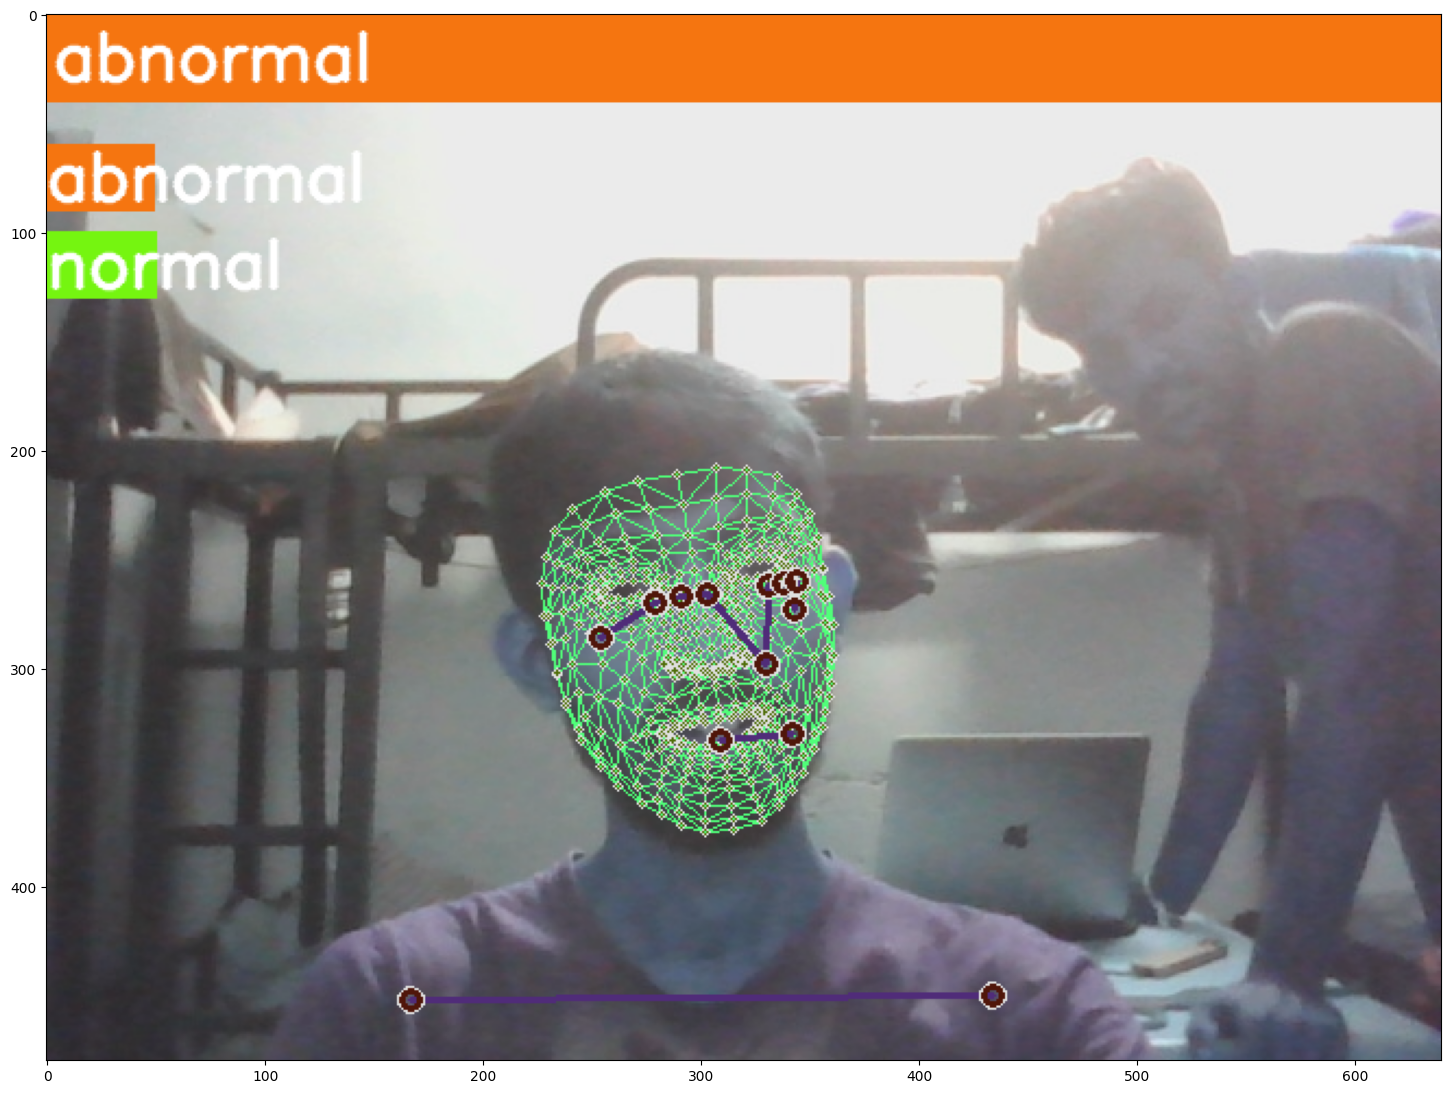

In [47]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [48]:
sequence.reverse()

In [49]:
len(sequence)

30

In [50]:
sequence.append('def')

In [51]:
sequence.reverse()

In [52]:
sequence[-30:]

[array([ 0.50574672,  0.65161145, -0.02552452, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.50481439,  0.65449786, -0.02505134, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51180005,  0.65527135, -0.02444383, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51218206,  0.6587618 , -0.02554034, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.51103991,  0.660065  , -0.02461069, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.50808215,  0.65920669, -0.02650291, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.50593311,  0.66034639, -0.02659428, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.50443101,  0.65928322, -0.02593817, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.50328326,  0.65921164, -0.02545394, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.50307089,  0.66130102, -0.02501578, ...,  0.        ,
         0.        ,  0.  

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [20]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
(num_sequences,30,1662)

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))